Merci de **ne pas modifier** le nom de ce notebook (même pour y inclure son nom).

Quelques conseils:
- pour exécutez une cellule, cliquez sur le bouton *Exécuter* ci-dessus ou tapez **Shift+Enter**
- si l'exécution d'une cellule prend trop de temps, sélectionner dans le menu ci-dessus *Noyau/Interrompre*
- en cas de très gros plantage *Noyau/Redémarrer*
- **sauvegardez régulièrement vos réponses** en cliquant sur l'icone disquette ci-dessus à gauche, ou *Fichier/Créer une nouvelle sauvegarde*

Pour répondre aux questions, remplacer les lignes ci-dessous par vos réponses: 
```python 
#LA REPONSE ICI
raise NotImplementedError()
``` 


---

# TD4 :  Chaînes de Markov

Ce TD a pour objectif d'explorer les propriétés des chaînes de Markov pour la résolution de problème statistique complexe et les simulations Monte-Carlo par chaînes de Markov.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Exercice 1 : problème du voyageur de commerce

Le problème du voyageur de commerce consiste en la traversée de $n$ villes par un voyageur qui doit minimiser la distance parcourue : $n$ villes sont disposées dans un espace à deux dimensions. Un voyageur doit parcourir ces $n$ villes puis revenir à son point de départ, tout en minimisant la longueur du trajet. Chaque chemin possible correspond à une permutation des villes. Comme le trajet effectué est un cycle, on peut se fixer une ville de départ. Il y a donc $(n−1)!/2$ chemins possibles. On pourrait  toutes  les  tester  mais  cela  prendrait  un  temps  trop  important étant donné  le  nombre  de  chemins  possibles. Songer que pour $n=100$, cela représente $10^{155}$ trajets, soit plus que d'atomes dans l'Univers.

Malgré la simplicité de son énoncé, il s'agit d'un problème d'optimisation pour lequel on ne connait pas d'algorithme permettant de trouver une solution exacte rapidement dans tous les cas. Plus précisément, on ne connait pas d'algorithme en temps polynomial, et sa version décisionnelle (pour une distance L, existe-t-il un chemin plus court que L passant par toutes les villes et qui termine dans la ville de départ ?) est un problème NP-complet, ce qui est un indice de sa difficulté. 

Dans cet exercice, on  utilise  donc  un  algorithme de recuit simulé utilisant une chaîne de Markov pour converger le plus rapidement possible, quoique sans 100% de garantie, vers un chemin optimal. Pour les tests, on prendra $n=10$ villes. Pour s'amuser vous pouvez prendre jusqu'à une centaine de villes et apprécier la rapidité de convergence de l'algorithme.

1. Générer $n$ positions $(x, y)$ aléatoires de villes dans un espace $[0,1]\times[0,1]$ à l'aide de `np.random.random`. Afficher le nombre de chemins possibles et représenter les positions des villes dans une figure.

*Astuce: à des fins de tests, on pourra aussi générer ces $n$ positions sur un cercle pour tester les algorithmes suivants, car le chemin le plus court est alors le parcours de la circonférence du cercle.*

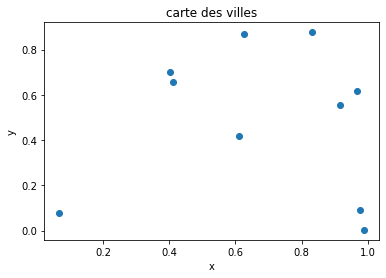

In [27]:
def villes(n=10): #renvoit un tableau à 2 colonnes avec dans l'une les x et dans l'autre les y et n lignes
    return np.random.random((n,2))

ville= villes(10)
v= ville.transpose()
x,y = v
fig = plt.figure()
plt.scatter(x,y)
plt.title("carte des villes")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

2. Créer une fonction qui retourne un cycle aléatoire de $n+1$ entiers: ce sera sous la forme d'une liste d'entiers $k \in [1, N-1]$ mélangés aléatoirement par la fonction [`np.random.shuffle`](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.shuffle.html) à laquelle on adjoint l'entier 0 au début et à la fin de la liste pour fermer le cycle. La ville 0 est donc considérée comme étant le point de départ et d'arrivée. Représenter ce cycle par une ligne passant par les villes générées à la question 1.

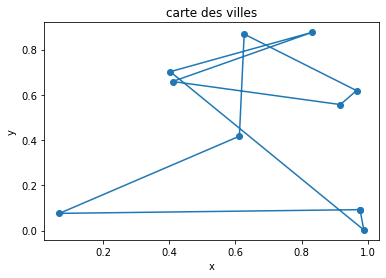

In [40]:
def cycle(n):
    liste = np.array(range(1,n), dtype = int)
    np.random.shuffle(liste)
    cycle = np.zeros(n+1, dtype= int)
    cycle[1:n] = liste
    return cycle

trajet  = cycle(10)
voyage = np.zeros((trajet.size,2))

for i in range(len(trajet)):
    voyage[i]= ville[(trajet[i])]

    
voy = voyage.transpose()
x,y = voy
fig = plt.figure()
plt.scatter(x,y)
plt.plot(x,y)
plt.title("carte des villes")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


3. Définir une fonction qui à partir des listes des positions des villes et d'un cycle d'entiers calcule la longueur euclidienne du chemin parcouru. On cherchera à la rendre la plus "vectorielle" possible grâce aux tableaux `numpy` pour la rendre la plus rapide possible.

In [85]:
def longueur(ville, cycle):
    long = 0
    voyage = np.zeros((cycle.size,2))
    voyage[0]= ville[(cycle[0])]
    
    for i in range(1,len(cycle)):
        voyage[i]= ville[cycle[i]]
        x1,y1 = voyage[i]
        x0, y0 =  voyage[i-1]
        long += np.sqrt((x1-x0)**2 + (y1-y0)**2)
    return long

l = longueur(ville,trajet)
print(l)

4.95536352065496


4. Définir une fonction `permutation(cycle)` qui tire deux entiers aléatoires $i,j$ dans l'intervalle $[1, N]$ et retourne une copie du cycle d'entrée dont les villes aux positions $i,j$ du cycle ont été permutées.

*Astuce: pour le tirage d'un entier aléatoire, on pourra utiliser [`np.random.randint`](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.randint.html).*

In [58]:
def permutation(cycle):
    tour = np.copy(cycle)
    i,j = np.random.randint(1,len(tour)-1, size = 2)
    tour[i]=cycle[j]
    tour[j]=cycle[i]
    return tour


[0 4 3 5 2 1 8 9 6 7 0]


5. **Algorithme de minimisation classique:** Tester d'abord un algorithme de recherche de minimum standard. Commencer par initialiser un cycle aléatoire, puis, dans une boucle limitée à $N_{\text{iter}}$ itérations, permuter deux villes alétoirement et garder le cycle s'il a une distance inférieure à celle du cycle précédent. Représenter le cycle final et l'évolution de la longueur du trajet au cours de la boucle. Commentaires ?

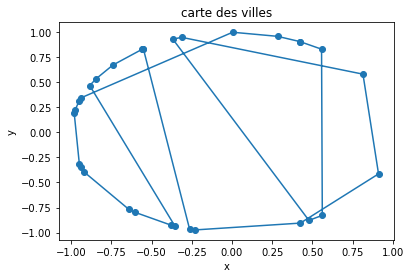

In [71]:
theta = np.random.uniform(0,2*np.pi, size = 30)
x = np.cos(theta)
y=np.sin(theta)
cercle = np.array([x,y]).transpose()


Niter = 10000
city = cercle
ordre = cycle(len(cercle))
l_chemin = longueur(city, ordre)

for i in range(Niter):
    new_ordre = permutation(ordre)
    new_l = longueur(city, new_ordre)
    if new_l < l_chemin :
        ordre = new_ordre
        l_chemin = new_l


voyage = np.zeros((ordre.size,2))
for i in range(len(ordre)):
    voyage[i]= city[(ordre[i])]

    
voy = voyage.transpose()
x,y = voy
fig = plt.figure()
plt.scatter(x,y)
plt.plot(x,y)
plt.title("carte des villes")
plt.xlabel("x")
plt.ylabel("y")
plt.show()
        


LA REPONSE ICI (double-clique pour editer la cellule)

**Première utilisation des chaînes de Markov** 

L'algorithme précédent échoue à donner le trajet optimal car il reste coincé dans des minima locaux, lesquels dépendent des conditions initiales. Pour sortir de l'ornière, on va utiliser les propriétés des chaînes de Markov. Pour cela l'idée est d'échantillonner une loi de probabilité qui favorise les trajets courts: si on pose $L(c)$ la longueur du cycle $c$, on peut penser à une densité de probabilité $\mu(c) \propto 1/L(c)$. Soit une chaîne sur les cycles $c$, où l'on passe d'un cycle $c_{t}$ à un autre $c_{t+1}$ par une permutation de deux éléments avec une probabilité $P(c_t, c_{t+1})$ que l'on munit de la probabilité de transition suivante:
$$ K(c_{t}, c_{t+1}) = \left\lbrace\begin{array}{ll}
q(c_{t}, c_{t+1}) & \text{ si } L(c_{t+1}) < L(c_t) \\
q(c_{t}, c_{t+1}) \frac{\mu(c_{t+1})}{\mu(c_{t})} & \text{ si } L(c_{t+1}) > L(c_t) 
\end{array}\right.$$
Cette chaîne est clairement Markovienne car sans mémoire (l'étape $t+1$ ne dépend que de l'étape $t$) et réversible. Par conséquent,   un théorème lié aux chaînes de Markov nous assure que celle-ci va converger vers la mesure invariante égale à $\mu(c)$ par construction, en un temps long. 

Comment implémenter la règle de transition $K(c_{t}, c_{t+1})$ ? *On utilise un algorihtme de Métropolis.* Préparer une boucle de $N_{\text{iter}}$ permutations réalisée sur un cycle initial tiré aléatoirement. Au cours de la boucle:
- si le ratio $\mu(c_{t+1})/\mu(c_t)$ est supérieur à 1, on garde le cycle $c_{t+1}$ pour la prochaine itération;
- sinon, tirer un nombre aléatoire $\alpha$ entre 0 et 1 et garder le cycle $c_{t+1}$  seulement si $\mu(c_{t+1})/\mu(c_t) > \alpha$.


6. Ecrire cet algorithme et représenter l'évolution de la longueur du cycle au cours de la boucle. Commentaires ?

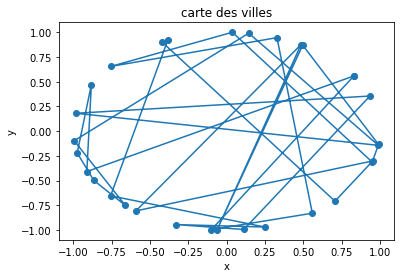

In [75]:
theta = np.random.uniform(0,2*np.pi, size = 30)
x = np.cos(theta)
y=np.sin(theta)
cercle = np.array([x,y]).transpose()


Niter = 1000
city = cercle
ordre = cycle(len(cercle))
L = longueur(city, ordre)

for i in range(Niter):
    new_ordre = permutation(ordre)
    new_l = longueur(city, new_ordre)
    
    
    if L/new_l >1 :
        ordre = new_ordre
        l_chemin = new_l
    elif L/new_l > np.random.random():
        ordre = new_ordre
        l_chemin = new_l
        
voyage = np.zeros((ordre.size,2))
for i in range(len(ordre)):
    voyage[i]= city[(ordre[i])]

    
voy = voyage.transpose()
x,y = voy
fig = plt.figure()
plt.scatter(x,y)
plt.plot(x,y)
plt.title("carte des villes")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

LA REPONSE ICI (double-clique pour editer la cellule)

**Algorithme de recuit simulé**

Une densité de probabilité $\pi(c) \propto 1/L(c)$ ne favorise pas assez les petites longueurs. Utilisons maintenant 
$$\mu(c) \propto e^{-\beta L(c)}$$
avec $\beta$ un paramètre assimilé à l'inverse d'une température. 

7. Choisir $\beta = 50$ et implémenter ce nouvel algorithme. Que constatez-vous ?
8. Pour assurer la convergence vers le chemin optimal, on va refroidir le système petit à petit. Rajouter une sur-boucle sur $\beta$ afin de progressivement refroidir la chaîne toutes les $N_{\text{iter}}$ itérations. Conclusion ?

<ipython-input-111-2cebf0307e10>:26: RuntimeWarning: invalid value encountered in double_scalars
  if mu_l/mu_L >1 or  mu_l/mu_L > np.random.random():


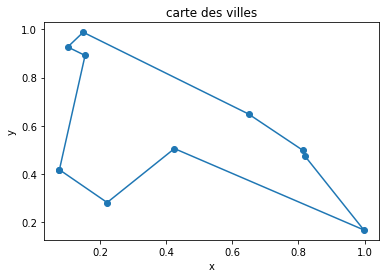

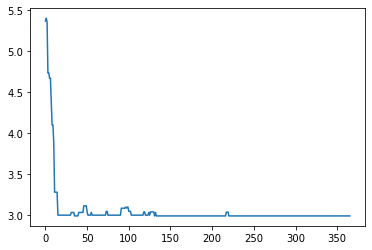

In [111]:
#beta =100

theta = np.random.uniform(0,2*np.pi, size = 10)
x = np.cos(theta)
y=np.sin(theta)
cercle = np.array([x,y]).transpose()


Niter = 1000
city = villes(10)
ordre = cycle(len(city))
L = longueur(city, ordre)
liste_l= []
liste_l.append(L)

for beta in [50,100,150,1000]:

    mu_L = np.exp(-beta * L)

    for i in range(1,Niter):
        new_ordre = permutation(ordre)
        new_l = longueur(city, new_ordre)
        mu_l = np.exp(-beta * new_l)
        
        
        if mu_l/mu_L >1 or  mu_l/mu_L > np.random.random():
            ordre = new_ordre
            L = new_l
            mu_L = mu_l
            liste_l.append(L)
   
        
voyage = np.zeros((ordre.size,2))
for i in range(len(ordre)):
    voyage[i]= city[(ordre[i])]
    
        
voy = voyage.transpose()
x,y = voy
fig1 = plt.figure()
plt.scatter(x,y)
plt.plot(x,y)
plt.title("carte des villes")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

fig2 = plt.figure()
plt.plot(liste_l)
plt.show()

LA REPONSE ICI (double-clique pour editer la cellule)

9. **Bonus:** Voici ci-dessous la liste des plus grandes villes françaises et leurs coordonnées géographiques en degrés. Trouver le chemin le plus court pour faire un tour de France à vol d'oiseau. On peut atteindre une longueur de 980 km seulement. 

In [ ]:
villes = [[0, 'PARIS', 'Paris', 48.857257, 2.344311],
[1, 'MARSEILLE', 'Marseille', 43.2958, 5.366067],
[2, 'LYON', 'Lyon', 45.762006, 4.832372],
[3, 'TOULOUSE', 'Toulouse', 43.606148, 1.435585],
[4, 'NICE', 'Nice', 43.712104, 7.255905],
[5, 'NANTES', 'Nantes', 47.219316, -1.556968],
[6, 'MONTPELLIER', 'Montpellier', 43.610498, 3.877936],
[7, 'STRASBOURG', 'Strasbourg', 48.574935, 7.748352],
[8, 'BORDEAUX', 'Bordeaux', 44.837663, -0.577904],
[9, 'LILLE', 'Lille', 50.62974, 3.054711],
[10, 'RENNES', 'Rennes', 48.117241, -1.677809],
[11, 'REIMS', 'Reims', 49.257329, 4.034491],
[12, 'LEHAVRE', 'Le Havre', 49.493329, 0.103028],
[13, 'SAINT-ETIENNE', 'Saint-Etienne', 45.439955, 4.389153],
[14, 'TOULON', 'Toulon', 43.124326, 5.927245],
[15, 'GRENOBLE', 'Grenoble', 45.18887, 5.727048],
[17, 'NIMES', 'Nimes', 43.833463, 4.351784],
[18, 'ANGERS', 'Angers', 47.471287, -0.551617],
[19, 'VILLEURBANNE', 'Villeurbanne', 45.771987, 4.89017]]

N = len(villes)
label = [ville[1] for ville in villes]
y = np.array([ville[3] for ville in villes])
x = np.array([ville[4] for ville in villes])
plt.plot(x, y, "bo")
plt.axis("equal")
for k in range(N):
    plt.annotate(label[k], (x[k], y[k]), textcoords="offset points", xytext=(0, 10), ha='center')
plt.show()

In [ ]:
#LA REPONSE ICI
raise NotImplementedError()

## Exercice 2 : modèle d'Ising

Le modèle d'Ising a été introduit dans les années 1920 par H. Lenz et E. Ising pour expliquer l'apparition d'une aimatation spontanée quand on refroidit un corps ferromagnétique en dessous d'une température appelée température de Curie. Dans un milieu ferromagnétique, les spins tendent à s'aligner tous ensemble ($\forall i, s_i = +1$ ou $\forall i, s_i=-1$) donc l'énergie d'interaction entre deux spins $i$ et $j$ voisins s'écrit $-Js_i s_j$ où $J$ est une constante d'interaction positive (pour un matériau antiferromagnétique, au contraire on impose $J<0$). S'il y a un champ magnétique extérieur, les spins tendent à s'aligner avec celui-ci et l'intéraction d'un spin $i$ avec ce champ s'écrit $=h s_i$ où $h$ est la valeur du champ extérieur (positif ou négatif). L'énergie d'un micro-état $\left\lbrace s_i \right\rbrace$ s'écrit 
$$H = - J \sum_{(i,j)} s_i s_j - h \sum_i s_i $$
où la double somme est réalisée sur toutes les paires de plus proches voisins (avec conditions aux limites périodiques). 

E. Ising a entièrement résolu le problème à une dimension en 1925, c'est-à-dire pour une chaîne linéaire de spins: le résultat principal est que  ce modèle ne possède aucune transition de phase. En 1944, L. Onsager réussit le tour de force de résoudre analytiquement le modèle à deux dimensions sur un réseau carré en champ nul. Il prouve l'existence d'une transition de phase du second ordre caractérisée par une température critique $T_c$ telle que $\sinh( 2J / k_B T_c) = 1$ avec $k_B$ la constante de Boltzmann. Finalement, C.N. Yang complète ces résultats en 1952 en montrant que l'aimantation moyenne $\left\langle M \right\rangle$ pour $T < T_c$ s'écrit
$$\left\langle M \right\rangle = \left[ 1 - \left(\sinh \frac{2J}{k_B T}\right)^{-4} \right]^{1/8},\qquad T_c = \frac{2 J}{k_B \ln \left( 1+ \sqrt{2}\right)}$$


On se placera dans un espace à deux dimensions, avec conditions aux limites périodiques, contenant $N\times N$ spins à la température $T$ avec un champ externe $h=0$ et $J=1$. A l'aide de chaînes de Markov sur les états $\left\lbrace s_i \right\rbrace$ nous allons en déduire des propriétés statistiques macroscopiques liées à la transition de phase dans un matériau ferromagnétique autour de la température critique $T_c$.



1. A l'aide des formules analytiques ci-dessus, calculer la température critique $T_c$ du système et représenter l'évolution de l'aimantation moyenne $\left\langle M\right\rangle$ avec la température $T$ selon la théorie de Onsager. Placer $T_c$ dans le graphe sous la forme d'une ligne verticale à l'aide de [`plt.axvline`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.axvline.html).

In [ ]:
kb = 1.38*e-23
Tc = 2/(kb * np.log(1+np.sqrt(2)))

def Aiman (T):
    

2. Créer une fonction qui génère, en une seule ligne, un tableau $N\times N$ spins valant aléatoirement +1 ou -1. On pourra utiliser la fonction [`np.random.choice`](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html). Représenter le tableau généré.

**Conseil:** on se limitera à $N=50$ car les calculs deviennent vite intensifs.

In [ ]:
#LA REPONSE ICI
raise NotImplementedError()

3. Créer une première fonction qui calcule l'énergie d'interaction associée à un spin $s_i$ en position $(m,n)$ dans un tableau de spins créé par la fonction précédente. On prendra des conditions aux limites périodiques. Puis créer une seconde fonction qui calcule l'énergie totale $H$.  

In [ ]:
#LA REPONSE ICI
raise NotImplementedError()

On ne connaît toujours pas la solution analytique pour le modèle d'Ising à trois dimensions ce qui justifierait l'utilisation de méthodes numériques. On se limite toutefois à deux dimensions afin d'éviter des temps de calculs extrêmement longs mais la généralisation à trois dimensions est facile. La procédure normale en physique statistique est de calculer l'énergie libre du système à la température $T$:
$$ F = -k_B T \ln Z(N^2, T, h) $$
où $Z$ est la fonction de partition:
$$ Z(N^2, T, h) = \sum_{s_1 = \pm 1} \sum_{s_2 = \pm 1}\cdots \sum_{s_{N^2} = \pm 1} e^{-\beta H} $$
avec $\beta = 1/ k_B T$. Connaissant l'énergie libre $F$ on peut alors calculer les grandeurs thermodynamiques dont on a besoin:
$$ E =- \frac{\partial \ln Z}{\partial \beta},\quad M = \left.\frac{\partial F }{\partial h}\right\vert_{h=0}$$
Mais calculer la fonction de partition est de toute évidence impossible dès que $N$ excède quelques dizaines puisqu'il y a $2^{N^2}$ termes et que chacun de ces termes a une complexité en $N^2$. 

Sachant qu'un micro-état $S_t$ a une probabilité $\mu_k = e^{-\beta H_t} / Z$ d'exister, l'idée pour obtenir des grandeurs thermodynamiques sur ce système est d'exploiter les propriétés des chaines de Markov pour échantillonner la loi de probabilité $\mu_k$ sans avoir à calculer $Z$. On se dote donc de la règle suivante: soit $q(S_t, S_{t+1})$ la probabilité de tirer le spin $s_i$ et de changer son signe pour passer du micro-état $S_t$ au micro-état $S_{t+1}$ ($q(S_t, S_{t+1})$ est une constante pour une loi de probabilité de tirage uniforme), alors considérons le noyau de transition:
$$ K(S_t, S_{t+1}) = \left\lbrace\begin{array}{ll}
q(S_{t}, S_{t+1}) & \text{ si } \mu_{t+1}/\mu_t > 1 \\
q(S_{t}, S_{t+1}) \frac{\mu(S_{t+1})}{\mu(S_{t})} & \text{ si } \mu_{t+1}/\mu_t < 1
\end{array}\right.$$
Cette chaîne de Markov est bien réversible et par conséquent on sait qu'elle va échantilloner en temps long sa mesure invariante $\mu$. 

Les états explorés par la chaîne vont donc explorer les micro-états associés au système avec la loi de probabilité de l'ensemble canonique. Par le principe d'ergodicité, la moyenne temporelle d'une grandeur macroscopique est égale à la moyenne de sa valeur explorée par les micro-états du système. Réaliser des études statistiques sur les états de la chaîne nous renseigne sur les grandeurs thermodynamiques associées. *Fait notable: à aucun moment il n'est nécessaire de calculer $Z$ car on en travaille qu'avec des rapports de $\mu_t$ !*


4. Ecrire une fonction qui renvoie une copie d'un micro-état $S_t$ dont un spin aléatoire $s_i$ en position $(m,n)$ a changé de signe. Les indices $n$ et $n$ seront tirés aléatoirement selon une loi de probabilité uniforme grâce à la fonction `np.random.randint`.  

In [ ]:
#LA REPONSE ICI
raise NotImplementedError()

5. A la manière de l'exercice précédent, écrire un algorithme de Métropolis-Hastings sur une chaîne de Markov  des micro-états $S_t$. On prendra $k_B=1$. Pour converger la chaîne a besoin d'au moins $N_{iter} = N^2$ itérations pour qu'elle ait le temps de visiter au moins une fois chaque site.

**Conseils pour significativement réduire les temps de calculs:**
* noter que la différence d'énergie $\Delta E$ entre deux états suite au changement du spin $s_i$ est simplement égale à -2 fois l'énergie du spin $s_i$;
* il est donc possible de ne calculer l'hamiltonien qu'une seule fois, au début de la chaîne;
* ne calculer l'exponentielle que dans le cas $\Delta E > 0$. 


6. Inclure cet algorithme dans une boucle sur la température $T$, dans le sens croissant et en partant d'un état $\forall i, s_i=1$ à température nulle pour accélérer la convergence de l'algorithme aux faibles températures (dans le sens décroissant il est rare et fortuit d'atteindre ce micro-état très particulier).

7. Pour chaque température $T$, représenter l'évolution de $E$ et $M$ le long de la chaine et réprésenter le dernier micro-état atteint.


In [ ]:
#LA REPONSE ICI
raise NotImplementedError()

8. Calculer l'énergie moyenne et l'aimantation moyenne du système sur la fin de la chaîne, lorsque celle-ci atteint un état à peu près stationnaire (quasi impossible autour de $T_c$). Les représenter en fonction de la température et superposer le modèle de Onsager. Qu'en pensez-vous ?

9. De même, calculer la capacité calorifique $c_V$ et la susceptibilité magnétique $\chi$ par
$$ c_V = \left.\frac{\partial E}{\partial T}\right\vert_V  = \frac{1}{k_B T^2}\left[\left\langle E^2\right\rangle - \left\langle E\right\rangle^2  \right] , \qquad \chi = \left.\frac{\partial M}{\partial h} \right\vert_{h=0}= \frac{1}{k_B T}\left[\left\langle M^2\right\rangle - \left\langle M\right\rangle^2  \right]$$
et les tracer en fonction de la température. 

**Conseil:** pour que ces moments d'ordre 2 sur la chaîne soient fiables, celle-ci doit être vraiment très longue...

10. Dans le modèle de Onsager, pour $T > T_c$ la susceptibilité vérifie $\chi \propto (T-T_c)^{-\gamma}$ avec $\gamma = 7/4$. Ajuster à la main les paramètres de cette loi en la superposant au graphe précédent. Qu'obtenez-vous pour $\gamma$ ? 

In [ ]:
#LA REPONSE ICI
raise NotImplementedError()

**Bonus:** reprendre l'exercice avec un champ externe $h$ non nul et/ou une valeur $J<0$.

## Exercice 3 : expansion de l'Univers et énergie noire

En 1929, E. Hubble met en évidence que plus les galaxies sont lointaines plus elles s'éloignent vite de nous. Cette confirmation observationnelle assoit les théories sur l'expansion de l'Univers que différents théoriciens avaient auparavant proposés, comme G. Lemaître ou A. Friedmann. Plus formellement, si on note $v$ la vitesse d'éloignement de l'astre par rapport à nous observateurs, et $D_L$ sa distance  (en mégaparsec Mpc), la loi d'expansion de l'Univers de Hubble-Lemaître s'écrit:
$$ v = H_0 D_L $$
avec $H_0$ la constante de Hubble qui aujourd'hui est mesurée à environ $70\,$km/s/Mpc.


En 1998, deux équipes indépendantes montrent que l'expansion de l'Univers est en réalité accélérée. La cause de cette accélération est nommée "énergie noire" mais sa nature réelle est aujourd'hui toujours inconnue même si plusieurs hypothèses sont avancées (constante fondamentale de la gravitation, énergie du vide, dimensions supplémentaires...). L'accélération a été mesurée via l'observation d'explosions hyper lumineuses d'étoiles lointaines appelées supernovae de type Ia. La particularité de ces explosions est qu'elles émettent toujours la même puissance lumineuse: par conséquent la mesure du flux reçu permet de remonter à leur distance car on sait que le flux se dilue comme la distance au carré. Concrètement, les flux reçus de ces explosions sont apparus plus faibles que prévus aux grandes distances, et ce d'autant plus qu'elles sont lointaines. Ceci signifie que pendant que le photon voyageait jusqu'à nous l'Univers a grandi plus vite que ce qui est prévu, donc il y a eu accélération de l'expansion.


L'effet de vitesse s'observe par un décalage "Doppler" dans les spectres des astres, et se mesure par le "décalage spectral vers le rouge" dit redshitf $z$
$$z  = \frac{\lambda_{obs}(v)-\lambda_0}{\lambda_0} $$
avec $\lambda_0$ la longueur d'onde du photon émis par l'astre et $\lambda_{obs}$ la longueur d'onde observée. Aujourd'hui, la version moderne de la loi de Hubble se décrit par la distance de luminosité $D_L(z)$ exprimée en fonction du redshift $z$ par:
$$
D_L(z) =  \left\lbrace\begin{array}{cl}
    \displaystyle{\frac{(1+z)c}{H_0\sqrt{-\Omega_k^0}}\sin\left[H_0\sqrt{-\Omega_k^0}\int_0^z\frac{dz'}{H(z')}\right]}  & \text{ si } \Omega_k^0<0 \\
    \displaystyle{(1+z)\int_0^z\frac{cd'z}{H(z')}} & \text{ si } \Omega_k^0=0 \\
    \displaystyle{\frac{(1+z)c}{H_0\sqrt{\Omega_k^0}}\sinh\left[H_0\sqrt{\Omega_k^0}\int_0^z\frac{dz'}{H(z')}\right] }  & \text{ si } \Omega_k^0>0
\end{array}
\right.
$$

* $c$ est la vitesse de la lumière dans le vide;
* $H(z)$ est la fonction de Hubble et qui dépend du contenu en énergie de l'Univers (matière, amtière noire, énergie noire, photons...);
* $\Omega_k^0$ est la densité d'énergie liée à la courbure de l'Univers: $\Omega_k^0=0$ plat, $\Omega_k^0>0$ hyperbolique, $\Omega_k^0<0$ sphérique.

A faible redshitf $z$, l'expression ci-dessus se réduit à la loi de Hubble-Lemaître. 



Le modèle standard de la cosmologie moderne considère un Univers uniquement rempli de matière et d'énergie noire: c'est le modèle $\Lambda$CDM. La fonction de Hubble se déduit des équations de la Relativité Générale et s'écrit:
$$ H^2(z) = H^2_0 \left[\Omega_m^0(1+z)^3 + \Omega_\Lambda^0 + \Omega_k^0(1+z)^2  \right], \quad \Omega_k^0=1 - \Omega_m^0 -  \Omega_\Lambda^0, \quad \Omega_m^0>0$$
avec $\Omega_m^0$ le paramètre lié à la densité d'énergie dans l'Univers e $ \Omega_\Lambda^0$ celui lié à la densité d'énergie noire. Lorsqu'on suppose que la matière occupe 100% du contenu de l'Univers, on note $\Omega_m^0=1$. C'est donc un modèle à 2 paramètres, $\Omega_m^0$ et $ \Omega_\Lambda^0$. 

La cellule suivante charge les données issues d'un des derniers relevés de supernovae de type Ia, nommé [JLA](https://arxiv.org/pdf/1401.4064.pdf), et donne leur magnitude (brillance) en fonction du redshift:

In [ ]:
z_sn, mag_sn, mag_err = np.loadtxt("./data/sne_data_sorted_corrected.txt")

plt.errorbar(z_sn, mag_sn, yerr=mag_err, linestyle="none", color="k", marker="+")
plt.grid()
plt.xlabel("Redshift $z$")
plt.ylabel("Magnitude des SNIa")
plt.show()


La fonction ci-dessous calcule la distance de luminosité normalisée $d_L(z) = D_L(z) H_0/c$ en fonction des paramètres du problème et de la fonction de Hubble normalisée $h(z) = H(z)/H_0$. On initialise une fonction $h(z)$ pour le modèle $\Lambda$CDM. 

In [ ]:
from scipy.integrate import quad

def dL(h_func, z, omegak0, *h_args):
    inv_h = lambda x: 1/h_func(x, *h_args)
    if abs(omegak0) < 1e-12:
        return (1+z) * quad(inv_h, 0, z)[0]
    else:
        if omegak0 > 0:
            return (1+z)/np.sqrt(omegak0) *np.sinh(np.sqrt(omegak0) * quad(inv_h, 0, z)[0])
        else:
            return (1+z)/np.sqrt(-omegak0) *np.sin(np.sqrt(-omegak0) * quad(inv_h, 0, z)[0])
       
def h_LCDM(z, omegam0, omegal0):
    omegak0 = 1 -omegam0 - omegal0
    return np.sqrt(omegam0*(1+z)**3 + omegak0*(1+z)**2 + omegal0 )

omegam0 = 0.3
omegal0 = 0.7
dL(h_LCDM, 1, 1-omegam0-omegal0, omegam0, omegal0)

La magnitude $m$ se déduit de la distance de luminosité normalisée par:
\begin{equation}
m_{\rm model}(z) = 5 \log_{10} d_L(z) + \mathcal{M}, \quad \mathcal{M} = 24.08
\end{equation}

1. Superposer sur un graphe les mesures de magnitudes des supernovae et la prédiction donné par le modèle d'un Univers composé uniquement de matière ($\Omega_\Lambda^0=0$). Puis, faites varier le pourcentage de matière  (on rappelle qu'il est raisonnable de supposer $\Omega_m^0>0$ puisque nous existons), toujours avec $\Omega_\Lambda^0=0$. Est-ce que le modèle semble pouvoir s'accorder aux données ? Quel ingrédient faut-il en plus ? Pour bien vérifier celà, tracer aussi la différence des données avec le modèle, que l'on nomme résidus.

In [ ]:
#LA REPONSE ICI
raise NotImplementedError()

LA REPONSE ICI (double-clique pour editer la cellule)

Pour bien comparer un modèle à des données, une bonne façon est de minimiser l'écart entre les deux via la minimisation d'un $\chi^2$:
$$ \chi^2 = \sum_i \left(\frac{m_{\rm model}(z_i)-m_i}{\sigma_i}\right)^2$$
avec $z_i, m_i$ et $\sigma_i$ respectivement le redshift, la magnitude et l'incertitude sur la magnitude de la supernova $i$. La fonction [`scipy.optimize.curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) réalise cette minimisation, mais nous allons ici utiliser des chaînes de Markov, bien que leur utilisation soit plus pertinente lorsqu'il y a beaucoup de paramètres dans le modèle.

Si l'on suppose que les mesures sont issues d'un processus gaussien et que $m_{\rm model}(z_i)$ est le véritable modèle $M(\Omega_m^0, \Omega_\Lambda^0)$ choisi par la Nature, alors la probabilité d'observer le jeu de données $D=\left\lbrace m_i \right\rbrace$ est données par:

$$ \mathcal{L}(D \vert M)  \propto \text{exp}\left\lbrace -\sum_i \left(\frac{m_{\rm model}(z_i, M)-m_i}{2\sigma_i}\right)^2 \right\rbrace \propto \text{exp}\left\lbrace -\chi^2(M)/2 \right\rbrace$$
si les mesures sont indépendantes. $\mathcal{L}(D \vert M)$ est appelée fonction de vraisemblance ou likelihood, et représente la probabilité d'observer $D$ sachant $M$. On reconnait là une forme de fonction déjà rencontrée dans l'utilisation des chaînes de Markov où l'écart entre données et modèle serait à minimiser avec une "température" proportionnelle aux incertitudes.

Comment minimiser cet écart et en déduire des propriétés sur $\Omega_m^0$ comme sa valeur moyenne, sa valeur au minimum ou encore son incertitude ? Il nous faut encore un dernier ingrédient: le théorème de Bayes:
$$\mu(M \vert D) = \frac{\mathcal{L}(D \vert M) \pi(M)}{\pi(D)} \propto e^{-\chi^2(M)/2} \pi(M)$$
où $\mu(M \vert D)$ est la probabilité du modèle $M$ sachant les données $D$ (donc nous donne la propabilité liée à $\Omega_m^0$ sachant les données), $\pi(D)$ est la probabilité d'avoir ces données (on la considérera comme une simple constante de normalisation inconnue), et $\pi(M)$ est le *prior* sur le modèle c'est-à-dire la connaissance prélable qu'on a sur lui. Dans notre cas le prior sur le modèle est une loi de probabilité uniforme qui interdit $\Omega_m^0<0$.

2. Ecrire une fonction $\chi^2(\Omega_m^0, \Omega_\Lambda^0)$ d'après les formules ci-dessus.
3. Ecrire une fonction prior $\pi(\Omega_m^0, \Omega_\Lambda^0)$ qui renvoie 0 si les conditions sur les paramètres sont violées, 1 sinon (pour le moment on ne met aucune condition sur $\Omega_\Lambda^0$).
4. Mettre en place un algorithme de Métropolis, avec une chaîne de Markov sur le vecteur de paramètre $\vec{\Omega} = (\Omega_m^0, \Omega_\Lambda^0)$. Pour passer d'un état $k$ de la chaîne au suivant:
    * on tire un vecteur $\tilde{\vec{\Omega}}$ au hasard selon une loi Gaussienne $\mathcal{G}(\vec{\Omega}_{k}, C)$ centrée sur $\vec{\Omega}_{k}$ avec une matrice de covariance $C$ que l'on prendra diagonale $C=c I_2$ avec une valeur $c$ que l'on ajustera pour améliorer la convergence de l'algorithme (commencer avec $c=0.001$); on utilisera [`np.random.multivariate_normal`](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.multivariate_normal.html) pour le tirage gaussien.
    * si le prior n'est pas vérifié, on reste sur le vecteur $\tilde{\vec{\Omega}}_{k}$ et on passe à l'itération suivante
    * si la valeur du $\chi^2$ diminue, on met à jour le vecteur $\vec{\Omega}_{k+1}$ avec $\tilde{\vec{\Omega}}$
    * sinon, on tire un nombre $\alpha$ selon une distribution uniforme $[0 , 1]$, et si $e^{(\chi^2_{k+1}-\chi^2_k )/2} > \alpha$ on accepte le tirage $\tilde{\vec{\Omega}}$, sinon on reste sur $\vec{\Omega}_{k}$
5. Tracer l'évolution du $\chi^2$ le long de la chaîne, ainsi que l'évolution des valeurs de $\Omega_m^0$ et $\Omega_\Lambda^0$. La chaîne vous semble-t-elle avoir converger ? Si cela vous semble trop lent, ajuster le paramètre $c$.


In [ ]:
#LA REPONSE ICI
raise NotImplementedError()

Comment obtenir des valeurs intéressantes sur les paramètres $\vec{\Omega}$ ? Si la chaîne de Markov a convergé vers sa mesure invariante $\mu(\Omega_m^0, \Omega_\Lambda^0\vert D)$, alors le principe ergodique nous dit qu'on peut extraire la valeur moyenne des paramètres et leur écart type en réalisant ces opérations sur la chaîne: ce seront respectivement les mesures et incertitudes associées à ces paramètres étant données les données $D$. 

Pour les questions ci-dessous, on retirera les premières étapes de la chaîne pour ne garder que la phase dans laquelle elle est dans un état stationnaire. La première phase s'appelle le "burn-in" et est très influencée par les conditions initiales. Pour cela il faut inspecter visuellement l'évolution de la chaîne en fonction de $k$.

6. Calculer la moyenne et l'écart type de $\Omega_m^0$ et $\Omega_\Lambda^0$.
7. Repérer et stocker les valeurs de $\Omega_m^0$ et $\Omega_\Lambda^0$ lorsque le $\chi^2$ a atteint sa valeur minimale: ce sont les valeurs les plus probables du modèle avec ces données.
8. Tracer les histogrammes 1D  pour $\Omega_m^0$ et $ \Omega_\Lambda^0 $ grâce à [`plt.hist`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist.html). Placer les valeurs moyennes et valeurs les plus probables dessus.
9. Tracer l'histogramme 2D $\left\lbrace \Omega_m^0, \Omega_\Lambda^0 \right\rbrace$ grâce à [`plt.hist2d`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist2d.html). Placer les valeurs moyennes et valeurs les plus probables dessus. Choissisez un nombre de bins adapté et une bonne échelle de couleur. S'il le faut, réaliser une chaîne plus longue.

In [ ]:
#LA REPONSE ICI
raise NotImplementedError()

10. Jetez un oeil à [l'article qui a publié les données utilisées dans ce TP](https://arxiv.org/pdf/1401.4064.pdf), en particulier à la figure 15 et à la table 5 de [cet article](https://arxiv.org/pdf/1605.02627.pdf). Comment se comparent vos valeurs ?

**Remarque:** dans ces articles, l'histogramme 2D représente des niveaux de confiance à 68% ($1\sigma$ d'une gaussienne) et 95% ($2\sigma$). Le contour à 68% donne une idée de l'écart type pour les paramètres.

LA REPONSE ICI (double-clique pour editer la cellule)

**Bonus:** Tester un modèle alternatif d'énergie noire. Ce modèle d'Univers est plat ($\Omega_k^0 = 0$) et l'énergie noire possède une équation d'état $w$ laissée libre dans le modèle (elle vallait $-1$ dans le modèle $\Lambda$CDM):
$$ H^2(z) = H^2_0 \left[\Omega_m^0(1+z)^3 + (1- \Omega_m^0)(1+z)^{-3(1+w)}  \right], \quad \Omega_m^0>0$$
Reproduire la figure 16 de l'article [JLA](https://arxiv.org/pdf/1401.4064.pdf) à partir de ce modèle à deux paramètres $\Omega_m^0, w$.

# Exercice facultatif

Reproduire les figures du cours avec un algorithme de Métropolis-Hastings appliqé à une distribution de Boltzmann pour une (ou des ) particule(s) piégée(s) dans un potentiel de Lennard-Jones à la température $T$. 

In [ ]:
#LA REPONSE ICI
raise NotImplementedError()

In [ ]:
#LA REPONSE ICI
raise NotImplementedError()

In [ ]:
#LA REPONSE ICI
raise NotImplementedError()